# RANDOM FOREST

### DATA IS THE IMBALANCED DATA WITH SELECTED FEATURES 

In [37]:
#start with all dependencies

import numpy as np
import pandas as pd
from Evaluation import *
import sklearn
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.preprocessing import Imputer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
%matplotlib inline
import imblearn
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [38]:
#Read in the data as pandas dataframe
data = 'Statcast_data.csv'

def load_data(file):
    '''Load the Statcast_data.csv file into a pandas dataframe.
       Resolve unnecessary column in csv file'''
    baseball = pd.read_csv(file, index_col = 0)
    baseball['description'] = baseball['description'].replace({'blocked_ball': 0, 'ball': 0, "called_strike": 1})
    baseball['position_x'] = baseball['release_pos_x'] + baseball['pfx_x']
    baseball['position_z'] = baseball['release_pos_z'] + baseball['pfx_z']
    baseball['pitch_name'] = baseball['pitch_name'].replace('Knuckle Curve', 'Curveball')
    baseball = baseball[baseball.pitch_name != 'Eephus'] 
    
    final_df = baseball.loc[:, ['p_throws','pitch_name', 'position_x', 'position_z', 
                           'release_spin_rate', 'sz_top', 'sz_bot','vx0', 'vy0', 'vz0', 'description']]

    final_df=pd.get_dummies(final_df, prefix = 'pitch')
    final_df['player_name'] = baseball['player_name']
    
    final_df = final_df.dropna()
    return final_df


bsb = load_data(data)
X = bsb.drop(columns = ['player_name', 'description'])
y = bsb['description']

X.head()



,position_x,position_z,release_spin_rate,sz_top,sz_bot,vx0,vy0,vz0,pitch_L,pitch_R,pitch_2-Seam Fastball,pitch_4-Seam Fastball,pitch_Changeup,pitch_Curveball,pitch_Cutter,pitch_Sinker,pitch_Slider,pitch_Split Finger
0,4.9868,5.6846,2314.0,3.2971,1.5059,-9.8035,-138.1130,0.1339,1,0,1,0,0,0,0,0,0,0
1,4.1077,6.3981,2324.0,3.3136,1.5730,-9.0084,-140.5865,-2.4218,1,0,0,1,0,0,0,0,0,0
2,2.3349,4.9982,2521.0,3.9119,1.7080,-3.7285,-117.3223,1.2140,1,0,0,0,0,0,0,0,1,0
3,4.4509,6.1538,2329.0,3.5553,1.5639,-12.0533,-139.3669,-5.1407,1,0,0,1,0,0,0,0,0,0
4,4.5827,5.8014,2437.0,3.3450,1.6241,-14.0287,-139.8559,-3.3434,1,0,0,1,0,0,0,0,0,0


# Random Forest
## 1: Without PCA
Without PCA

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 777)

forest = RandomForestClassifier()
sampler = RandomUnderSampler(ratio = 1, random_state=777)

forest_pipe_no_pca = Pipeline(steps = [
    ('sampler', sampler),
    ('forest', forest)])

forest_pipe_no_pca_results = cross_validate(forest_pipe_no_pca, X_train, y_train, 
                            scoring = ['accuracy', 'f1', 'roc_auc'], 
                            cv =5, return_estimator=True, return_train_score = True)

for result in ['train_accuracy', 'test_accuracy', 'train_f1', 'test_f1', 'train_roc_auc', 'test_roc_auc']:
    print(f"Mean {result} Value: {np.mean(forest_pipe_no_pca_results[result])}")
    print(f"{result} scores: {forest_pipe_no_pca_results[result]}")
    print() 

Mean train_accuracy Value: 0.9404330230113601
train_accuracy scores: [0.93803199 0.93999526 0.9433025  0.94045643 0.94037894]

Mean test_accuracy Value: 0.8349813545799802
test_accuracy scores: [0.82460209 0.8334036  0.83941183 0.83693475 0.8405545 ]

Mean train_f1 Value: 0.9142389027831946
train_f1 scores: [0.91101398 0.91367479 0.91801779 0.91432363 0.91416431]

Mean test_f1 Value: 0.7592833165443857
test_f1 scores: [0.74505899 0.75809291 0.76440114 0.76225603 0.76660751]

Mean train_roc_auc Value: 0.9902064541176785
train_roc_auc scores: [0.98941222 0.99028346 0.99055687 0.99073891 0.9900408 ]

Mean test_roc_auc Value: 0.9082778195992155
test_roc_auc scores: [0.89767623 0.90709583 0.91350974 0.9099098  0.91319749]



In [41]:
predictions = forest_pipe_no_pca_results['estimator'][0].predict(X_test)

def eval_test_set(x_test_predictions, y_test):
    print(f"Accuracy Score: {metrics.accuracy_score(y_test, x_test_predictions)}")
    print()
    print(f"AUC Score: {metrics.roc_auc_score(y_test, x_test_predictions)}")
    print()
    print(f"F1 Score: {metrics.f1_score(y_test, x_test_predictions)}")
    print()
    print(f"Classification Report: \n {metrics.classification_report(y_test, x_test_predictions)}")
    print()
    print(f" Confustion Matrix: \n {metrics.confusion_matrix(y_test, x_test_predictions)}")

eval_test_set(predictions, y_test)



Accuracy Score: 0.821522309711286

AUC Score: 0.8154673701241619

F1 Score: 0.7424007302601551

Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.83      0.86     21437
           1       0.69      0.80      0.74     10186

   micro avg       0.82      0.82      0.82     31623
   macro avg       0.80      0.82      0.80     31623
weighted avg       0.83      0.82      0.82     31623


 Confustion Matrix: 
 [[17846  3591]
 [ 2053  8133]]


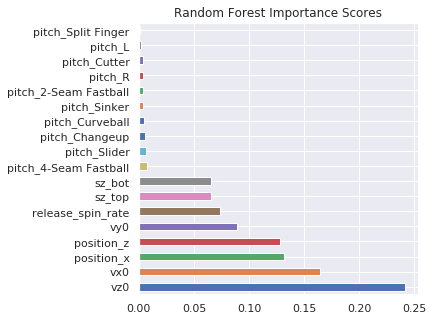

In [62]:
forest_clf = forest_pipe_no_pca_results['estimator'][0].steps[1][1]

#show feature importances
fig = plt.figure(figsize = (5,5))
importances = pd.Series(forest_clf.feature_importances_, index=X_train.columns) \
.sort_values(ascending = False).plot(kind = 'barh', title='Random Forest Importance Scores')
fig.savefig('images/random_forest_feat_imp.png', bbox_inches = 'tight')

In [36]:
#save the model for future use. 
from sklearn.externals import joblib

filename = 'Models/random_forest.sav'
joblib.dump(forest_pipe_no_pca_results['estimator'][0], filename)

['Models/random_forest.sav']

## Tuning



In [26]:
from skopt import BayesSearchCV

ITERATIONS = 50
bayes_cv_tuner = BayesSearchCV(
    estimator = forest_pipe_no_pca,
    search_spaces = {
        'forest__min_samples_split': (0.01, 1.0),
        'forest__max_depth': (1, 50),
        'forest__min_samples_leaf': (0.01, 0.5 ),
        'forest__max_features': (0.01, 1.0, ),
        'forest__n_estimators': (50, 750),
    },
    scoring = 'roc_auc',
    cv = 3,
    n_jobs = -1,
    n_iter = ITERATIONS,   
    verbose = 0,
    refit = True,
    random_state = 2019)

def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))

In [27]:
results = bayes_cv_tuner.fit(X_train, y_train, callback=status_print)

Model #1
Best ROC-AUC: 0.5
Best params: {'forest__max_depth': 31, 'forest__max_features': 0.9543275764819017, 'forest__min_samples_leaf': 0.4203923505859177, 'forest__min_samples_split': 0.2555369699930762, 'forest__n_estimators': 86}

Model #2
Best ROC-AUC: 0.5
Best params: {'forest__max_depth': 31, 'forest__max_features': 0.9543275764819017, 'forest__min_samples_leaf': 0.4203923505859177, 'forest__min_samples_split': 0.2555369699930762, 'forest__n_estimators': 86}

Model #3
Best ROC-AUC: 0.5
Best params: {'forest__max_depth': 31, 'forest__max_features': 0.9543275764819017, 'forest__min_samples_leaf': 0.4203923505859177, 'forest__min_samples_split': 0.2555369699930762, 'forest__n_estimators': 86}

Model #4
Best ROC-AUC: 0.5
Best params: {'forest__max_depth': 31, 'forest__max_features': 0.9543275764819017, 'forest__min_samples_leaf': 0.4203923505859177, 'forest__min_samples_split': 0.2555369699930762, 'forest__n_estimators': 86}

Model #5
Best ROC-AUC: 0.5
Best params: {'forest__max_de

In [28]:
forest_best = results.best_estimator_

predictions = forest_best.predict(X_test)

eval_test_set(predictions, y_test)

Accuracy Score: 0.7333270088226923

AUC Score: 0.7552854637565968

F1 Score: 0.6637157554731428

Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.69      0.78     21437
           1       0.56      0.82      0.66     10186

   micro avg       0.73      0.73      0.73     31623
   macro avg       0.72      0.76      0.72     31623
weighted avg       0.78      0.73      0.74     31623


 Confustion Matrix: 
 [[14868  6569]
 [ 1864  8322]]


In [29]:
from sklearn.externals import joblib

filename = 'Models/tuned_random_forest.sav'
joblib.dump(forest_best, filename)

['Models/tuned_random_forest.sav']

## With PCA


In [8]:
forest_pipe_with_pca_cv_results_lst = []
for n_components in [2,3,4,5,6]:
    print(f"Number of Components: {n_components}")
    print('-'*75)
    print()
    pca = PCA(n_components=n_components)
    
    pipe = Pipeline(steps = [
        ('sampler', sampler), #RandomUnderSampler(ratio = 1, random_state = 777)
        ('pca', pca),
        ('forest', forest)
    ])
    
    forest_pipe_with_pca_results = cross_validate(pipe, X_train, y_train, scoring = ['accuracy', 'f1', 'roc_auc'], 
                                cv =5, return_estimator=True, return_train_score = True)

    forest_pipe_with_pca_cv_results_lst.append(forest_pipe_with_pca_results)
    for result in ['train_accuracy', 'test_accuracy', 'train_f1', 'test_f1', 'train_roc_auc', 'test_roc_auc']:
        print(f"Mean {result} Value: {np.mean(forest_pipe_with_pca_results[result])}")
        print(f"{result} scores: {forest_pipe_with_pca_results[result]}")
        print() 

Number of Components: 2
---------------------------------------------------------------------------

Mean train_accuracy Value: 0.8301139497683728
train_accuracy scores: [0.82826047 0.83052679 0.83110654 0.83093525 0.8297407 ]

Mean test_accuracy Value: 0.5338470660640378
test_accuracy scores: [0.53378307 0.53104248 0.53304522 0.53578581 0.53557875]

Mean train_f1 Value: 0.7831178832314525
train_f1 scores: [0.78102214 0.78357732 0.78410699 0.78389167 0.7829913 ]

Mean test_f1 Value: 0.3758667839824166
test_f1 scores: [0.37739302 0.36857792 0.37332013 0.37814177 0.38190109]

Mean train_roc_auc Value: 0.9263990644949673
train_roc_auc scores: [0.92565301 0.9266203  0.92653494 0.92733279 0.92585428]

Mean test_roc_auc Value: 0.5141708707476396
test_roc_auc scores: [0.51449768 0.50964957 0.51157475 0.52026472 0.51486764]

Number of Components: 3
---------------------------------------------------------------------------

Mean train_accuracy Value: 0.8495541178386616
train_accuracy scores: [

In [10]:
best_forest_pipe_with_pca_predictions = forest_pipe_with_pca_cv_results_lst[-1]['estimator'][0].predict(X_test)

eval_test_set(best_forest_pipe_with_pca_predictions, y_test)

Accuracy Score: 0.8916611327198558

AUC Score: 0.8888668892663723

F1 Score: 0.8397117993824272

Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.90      0.92     21437
           1       0.80      0.88      0.84     10186

    accuracy                           0.89     31623
   macro avg       0.87      0.89      0.88     31623
weighted avg       0.90      0.89      0.89     31623


 Confustion Matrix: 
 [[19223  2214]
 [ 1212  8974]]
